In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Acquire the data

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 2s 0us/step


## EDA

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


#### Show Images

Use the PIL (Python Imaging Library) library to print images under a python console. They need to be in a 'printable' format like jpeg, png etc

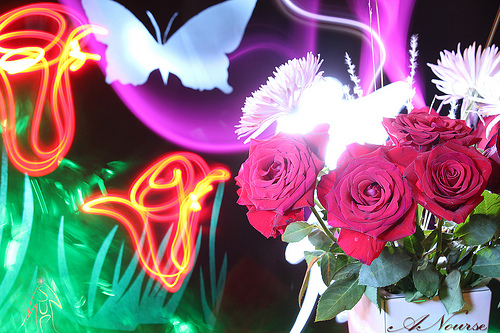

In [7]:
# Printing some roses from Roses folder under the data
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

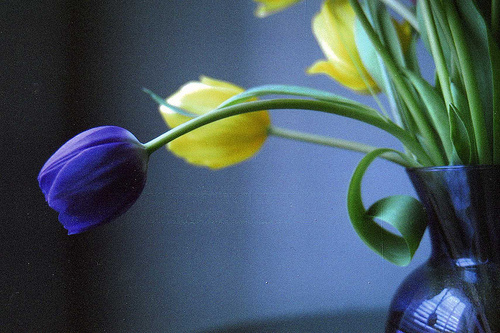

In [9]:
# And, some tulips
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

## Convert Images to TF Dataset using Keras

In [10]:
# Define user inputs

batch_size = 32
img_height = 180
img_width = 180

In [12]:
# Create the training dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
                                                        data_dir,
                                                        validation_split=0.2,
                                                        subset="training",
                                                        seed=123,
                                                        image_size=(img_height, img_width),
                                                        batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
                                                      data_dir,
                                                      validation_split=0.2,
                                                      subset="validation",
                                                      seed=123,
                                                      image_size=(img_height, img_width),
                                                      batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.
